# Data Access

Taken from a notebook created by Tyler Sutterly for the 2022 ICESat-2 Hackweek, put on by the e-science institute at UW.  
Use conda env sliderule  

Install new version of sliderule:  
"But if you do a **git pull** in your sliderule-python repo and then to a **python setup.py install**, it should resolve the issue."  
https://icesat-2sliderule.slack.com/archives/CTW2ESWFP/p1638199956016000

In [7]:
import os
import geopandas as gpd
import ipyleaflet
import ipywidgets as widgets
import logging
#import panel as pn
#pn.extension()
import matplotlib.lines
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from shapely.geometry import Polygon
import warnings
# grimp and nisar functions
#import grimpfunc as grimp
#import nisardev as nisar
# sliderule functions
import sliderule.icesat2
import sliderule.io
import sliderule.ipysliderule
import pandas as pd
from datetime import datetime
# register progress bar and set workers
#ProgressBar().register()
#dask.config.set(num_workers=2)
# turn off warnings for demo
warnings.filterwarnings('ignore')

In [8]:
%matplotlib inline

In [9]:
# set the url for the sliderule service
# set the logging level
sliderule.icesat2.init("icesat2sliderule.org", loglevel=logging.WARNING)

In [11]:
# display widgets for setting SlideRule parameters
SRwidgets = sliderule.ipysliderule.widgets()
# show widgets
widgets.VBox([
    SRwidgets.asset,
    SRwidgets.release,
    SRwidgets.surface_type,
    SRwidgets.length,
    SRwidgets.step,
    SRwidgets.confidence,
    SRwidgets.land_class,
    SRwidgets.iteration,
    SRwidgets.spread,
    SRwidgets.count,
    SRwidgets.window,
    SRwidgets.sigma
])

In [13]:
widgets.VBox([SRwidgets.projection, SRwidgets.layers])

In [14]:
polygon_gdf = gpd.read_file('UpperTuolRiverBasinOutline.geojson', crs='epsg:4326')
polygon_gdf.head()

,DN,geometry
0,0,"MULTIPOLYGON (((-119.79834 37.95837, -119.7980..."
1,1,"MULTIPOLYGON (((-119.58991 38.18616, -119.5888..."


In [15]:
polygon_gdf = polygon_gdf[1:]

In [16]:
gdf_exploded = polygon_gdf.explode()

In [17]:
polygon_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

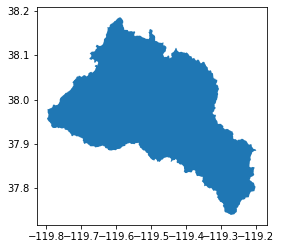

In [18]:
gdf_exploded.plot()

In [19]:
gdf_exploded.type

1  0    Polygon
dtype: object

In [20]:
# create ipyleaflet map in specified projection
m = sliderule.ipysliderule.leaflet(SRwidgets.projection.value)
m.add_layer(layers=SRwidgets.layers.value)

# Comment this section out if you want to draw your own polygon!
# ---
#box = shapely.geometry.Polygon([(-108.3,38.9), (-108.0,38.9), (-108.0,39.1), (-108.3, 39.1)])
#geobox = gpd.GeoDataFrame(geometry=[box], crs='EPSG:4326')
default_polygon = sliderule.io.from_geodataframe(gdf_exploded)
geodata = ipyleaflet.GeoData(geo_dataframe=gdf_exploded)
m.map.add_layer(geodata)
# ---

m.map

Map(center=[39, -108], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [21]:
#%%time
# sliderule asset and data release
asset = SRwidgets.asset.value
release = SRwidgets.release.value

# build sliderule parameters using latest values from widget
params = {
    # surface type: 0-land, 1-ocean, 2-sea ice, 3-land ice, 4-inland water
    "srt": SRwidgets.surface_type.index,
    # length of ATL06-SR segment in meters
    "len": SRwidgets.length.value,
    # step distance for successive ATL06-SR segments in meters
    "res": SRwidgets.step.value,
    # confidence level for PE selection
    "cnf": SRwidgets.confidence.value,
    # ATL08 land surface classifications
    "atl08_class": list(SRwidgets.land_class.value),
    # maximum iterations, not including initial least-squares-fit selection
    "maxi": SRwidgets.iteration.value,
    # minimum along track spread
    "ats": SRwidgets.spread.value,
    # minimum PE count
    "cnt": SRwidgets.count.value,
    # minimum height of PE window in meters
    "H_min_win": SRwidgets.window.value,
    # maximum robust dispersion in meters
    "sigma_r_max": SRwidgets.sigma.value
}

region = sliderule.icesat2.toregion(gdf_exploded)
params["poly"] = region["poly"]   # will always be the convex hull of the polygon
params["raster"] = region["raster"]   # raster will include all vertices, including holes. This is more processing, but is only an issue with very large requests.
gdf = sliderule.icesat2.atl06p(params, asset, version=release)

In [54]:
print(f'Returned {gdf.shape[0]} records')
gdf.head()

Returned 153237 records


,gt,dh_fit_dy,rms_misfit,segment_id,h_sigma,cycle,w_surface_window_final,pflags,n_fit_photons,spot,dh_fit_dx,distance,h_mean,rgt,delta_time,geometry,acqdate,acqdate_string,elev_plus
time,,,,,,,,,,,,,,,,,,,
2018-10-15 23:22:20.018965444,30,0.0,0.091912,210188,0.033182,1,3.0,0,15,4,-0.018228,4.215353e+06,2501.377184,265,2.488094e+07,POINT (-119.62341 37.88878),2018-10-15,2018-10-15,2502.377184
2018-10-15 23:22:20.021811344,30,0.0,0.109110,210189,0.028329,1,3.0,0,18,4,-0.010939,4.215373e+06,2501.116873,265,2.488094e+07,POINT (-119.62343 37.88896),2018-10-15,2018-10-15,2502.116873
2018-10-15 23:22:20.027481712,30,0.0,0.107823,210191,0.032855,1,3.0,0,11,4,-0.000515,4.215413e+06,2501.053838,265,2.488094e+07,POINT (-119.62348 37.88932),2018-10-15,2018-10-15,2502.053838
2018-10-15 23:22:20.030305900,30,0.0,0.156936,210192,0.041974,1,3.0,0,14,4,0.008181,4.215434e+06,2501.176924,265,2.488094e+07,POINT (-119.62350 37.88950),2018-10-15,2018-10-15,2502.176924
2018-10-15 23:22:20.033126928,30,0.0,0.169124,210193,0.045422,1,3.0,0,14,4,0.004802,4.215454e+06,2501.271832,265,2.488094e+07,POINT (-119.62352 37.88968),2018-10-15,2018-10-15,2502.271832


In [23]:
gdf.tail()

,gt,dh_fit_dy,rms_misfit,segment_id,h_sigma,cycle,w_surface_window_final,pflags,n_fit_photons,spot,dh_fit_dx,distance,h_mean,rgt,delta_time,geometry
time,,,,,,,,,,,,,,,,
2022-04-03 23:07:03.021534736,30,0.0,0.151252,792239,0.010309,15,3.0,0,223,3,0.000002,1.586837e+07,3177.548636,181,1.342624e+08,POINT (-119.27536 37.76555)
2022-04-03 23:07:03.024358512,30,0.0,0.136410,792240,0.011471,15,3.0,0,160,3,-0.006316,1.586839e+07,3177.465644,181,1.342624e+08,POINT (-119.27538 37.76537)
2022-04-03 23:07:03.027180256,30,0.0,0.087318,792241,0.007520,15,3.0,0,137,3,0.000720,1.586841e+07,3177.406060,181,1.342624e+08,POINT (-119.27540 37.76519)
2022-04-03 23:07:03.029999344,30,0.0,0.085847,792242,0.006324,15,3.0,0,187,3,0.000421,1.586843e+07,3177.414885,181,1.342624e+08,POINT (-119.27543 37.76501)
2022-04-03 23:07:03.032816528,30,0.0,0.078563,792243,0.006838,15,3.0,0,170,3,0.001723,1.586845e+07,3177.429574,181,1.342624e+08,POINT (-119.27545 37.76483)


In [24]:
gdf.index.is_unique

True

In [28]:
# gdf.time = pd.DatetimeIndex(gdf.time)
# gdf = gdf.set_index(['time'])

gdf.sort_index(inplace=True)
gdf['acqdate'] = gdf.index.date
gdf['acqdate_string'] = gdf['acqdate'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))

In [30]:
#gdf = gdf.drop(columns=['acqdate','acqdate_string'])

In [29]:
gdf.head(2)

,gt,dh_fit_dy,rms_misfit,segment_id,h_sigma,cycle,w_surface_window_final,pflags,n_fit_photons,spot,dh_fit_dx,distance,h_mean,rgt,delta_time,geometry,acqdate,acqdate_string
time,,,,,,,,,,,,,,,,,,
2018-10-15 23:22:20.018965444,30,0.0,0.091912,210188,0.033182,1,3.0,0,15,4,-0.018228,4.215353e+06,2501.377184,265,2.488094e+07,POINT (-119.62341 37.88878),2018-10-15,2018-10-15
2018-10-15 23:22:20.021811344,30,0.0,0.109110,210189,0.028329,1,3.0,0,18,4,-0.010939,4.215373e+06,2501.116873,265,2.488094e+07,POINT (-119.62343 37.88896),2018-10-15,2018-10-15


In [30]:
gdf.acqdate.unique()

array([datetime.date(2018, 10, 15), datetime.date(2018, 11, 13),
       datetime.date(2018, 12, 11), datetime.date(2019, 1, 9),
       datetime.date(2019, 2, 12), datetime.date(2019, 3, 12),
       datetime.date(2019, 4, 10), datetime.date(2019, 5, 14),
       datetime.date(2019, 6, 11), datetime.date(2019, 7, 9),
       datetime.date(2019, 7, 15), datetime.date(2019, 8, 7),
       datetime.date(2019, 8, 13), datetime.date(2019, 9, 9),
       datetime.date(2019, 10, 8), datetime.date(2019, 10, 14),
       datetime.date(2019, 11, 12), datetime.date(2019, 12, 9),
       datetime.date(2019, 12, 11), datetime.date(2020, 1, 7),
       datetime.date(2020, 1, 13), datetime.date(2020, 2, 5),
       datetime.date(2020, 2, 11), datetime.date(2020, 3, 9),
       datetime.date(2020, 3, 10), datetime.date(2020, 4, 7),
       datetime.date(2020, 4, 12), datetime.date(2020, 6, 8),
       datetime.date(2020, 7, 7), datetime.date(2020, 7, 12),
       datetime.date(2020, 8, 5), datetime.date(2020, 8, 10

In [31]:
gdf['elev_plus'] = gdf['h_mean'] + 1

In [32]:
widgets.VBox([
    SRwidgets.variable,
    SRwidgets.cmap,
    SRwidgets.reverse,
])

In [33]:
widgets.DatePicker(
    description='Pick a Date',
    disabled=False
)


DatePicker(value=None, description='Pick a Date')

In [38]:
start_date = datetime(2018, 11, 10)
end_date = datetime(2022, 3, 1)

dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime(' %d %b %Y '), date) for date in dates]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

selection_range_slider


SelectionRangeSlider(description='Dates', index=(0, 1207), layout=Layout(width='500px'), options=((' 10 Nov 20…

In [40]:
m.GeoData(gdf, column_name=SRwidgets.variable.value, cmap='viridis',
    max_plot_points=10000, tooltip=True, colorbar=True)

ValueError: Can't clean for JSON: datetime.date(2018, 10, 15)

In [37]:
date = dict(zip(gdf[''].tolist(), africa[‘pop_est’].tolist()))
africa[[“name”, “geometry”]].to_file(“data/africa.json”, driver=”GeoJSON”, encoding=’utf-8')
geojson_data = json.load(open(“data/africa.json”,’r’))for feature in geojson_data[‘features’]:
     properties = feature[‘properties’]
     feature.update(id=properties[‘name’])
     #print(feature[‘id’])

SyntaxError: invalid character '‘' (U+2018) (853659073.py, line 1)

#### Create plots for a single track

In [41]:
# selection for reference ground track
RGTs = [str(int(x)) for x in gdf.rgt.unique()]
SRwidgets.rgt = widgets.Dropdown(
    options=RGTs,
    value=RGTs[1], # You can change this with the pull-down widget below!
    description="RGT:",
    description_tooltip="RGT: Reference Ground Track to plot",
    disabled=False
)

# selection for ground track
ground_track_options = ["gt1l","gt1r","gt2l","gt2r","gt3l","gt3r"]
SRwidgets.ground_track = widgets.Dropdown(
    options=ground_track_options,
    value='gt1l',
    description="Track:",
    description_tooltip="Track: Ground Track to plot",
    disabled=False
)      
widgets.VBox([
    SRwidgets.rgt,
    SRwidgets.ground_track,
])

In [43]:
gdf.index = gdf.index.astype(str)

In [44]:
type(gdf.index)

pandas.core.indexes.base.Index

In [45]:
!pwd

/Users/zachkeskinen/Documents/isce_sat2/contributors/keskinen


In [49]:
fn = 'tuolumne_all_sr-atl06-07072022.geojson'

In [50]:
gdf.to_file(fn, driver='GeoJSON')

ValueError: Invalid field type <class 'datetime.date'>

In [51]:
gdf2 = gpd.read_file(fn)

In [52]:
gdf2.head()

,geometry


In [53]:
type(gdf2.index)

pandas.core.indexes.base.Index

In [36]:
gdf2['time'] = pd.to_datetime(gdf2['time'])

In [37]:
gdf2['time'].is_unique

False

In [ ]:
gdf2['time'].is_unique

In [38]:
gdf2.loc[gdf2['time'].duplicated(), :]

,time,dh_fit_dy,spot,distance,rms_misfit,h_mean,n_fit_photons,gt,cycle,pflags,dh_fit_dx,segment_id,delta_time,w_surface_window_final,rgt,h_sigma,geometry
592,2018-10-15 23:22:23.239830,0.0,1,4.235962e+06,0.731159,2680.460942,25,60,1,0,-0.145340,211216,2.488094e+07,4.708640,265,0.147852,POINT (-119.60886 38.07639)
1392,2018-12-11 08:53:00.829348,0.0,3,1.582499e+07,0.283177,3095.413626,348,40,1,0,-0.020657,790084,2.975358e+07,3.000000,1126,0.015187,POINT (-119.59177 38.16253)
1470,2018-12-11 08:53:00.899697,0.0,4,1.582790e+07,0.510451,3128.216908,11,30,1,0,0.445121,790229,2.975358e+07,11.367048,1126,0.163626,POINT (-119.59401 38.13639)
1833,2018-12-11 08:53:01.266189,0.0,4,1.583051e+07,0.110505,2686.555516,109,30,1,0,-0.001470,790359,2.975358e+07,3.000000,1126,0.010586,POINT (-119.59683 38.11302)
3625,2018-12-11 08:53:02.593409,0.0,1,1.583764e+07,0.812327,2591.292935,341,60,1,0,0.090070,790715,2.975358e+07,5.209235,1126,0.044021,POINT (-119.64185 38.05185)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150742,2022-02-06 13:36:14.034730,0.0,3,4.231081e+06,0.370924,2660.601950,52,30,14,0,0.194374,210973,1.293898e+08,4.994133,707,0.053508,POINT (-119.40826 38.02775)
150879,2022-02-06 13:36:14.113722,0.0,1,4.231522e+06,0.363350,3018.087503,214,10,14,0,0.175968,210995,1.293898e+08,4.528675,707,0.024855,POINT (-119.44479 38.02896)
151262,2022-02-06 13:36:14.364511,0.0,1,4.233306e+06,0.523910,2921.381387,55,10,14,0,0.406691,211084,1.293898e+08,10.388640,707,0.071765,POINT (-119.44675 38.04496)
151296,2022-02-06 13:36:14.386929,0.0,2,4.231061e+06,0.284173,2951.287686,13,20,14,0,0.058483,210972,1.293898e+08,3.007974,707,0.084227,POINT (-119.44333 38.02489)


In [41]:
gdf2['time'].duplicated().sum()

153

In [27]:
gdf2.head()

,time,dh_fit_dy,spot,distance,rms_misfit,h_mean,n_fit_photons,gt,cycle,pflags,dh_fit_dx,segment_id,delta_time,w_surface_window_final,rgt,h_sigma,geometry
0,2018-10-15 23:22:20.018965,0.0,4,4.215353e+06,0.091912,2501.377184,15,30,1,0,-0.018228,210188,2.488094e+07,3.0,265,0.033182,POINT (-119.62341 37.88878)
1,2018-10-15 23:22:20.021811,0.0,4,4.215373e+06,0.109110,2501.116873,18,30,1,0,-0.010939,210189,2.488094e+07,3.0,265,0.028329,POINT (-119.62343 37.88896)
2,2018-10-15 23:22:20.027481,0.0,4,4.215413e+06,0.107823,2501.053838,11,30,1,0,-0.000515,210191,2.488094e+07,3.0,265,0.032855,POINT (-119.62348 37.88932)
3,2018-10-15 23:22:20.030306,0.0,4,4.215434e+06,0.156936,2501.176924,14,30,1,0,0.008181,210192,2.488094e+07,3.0,265,0.041974,POINT (-119.62350 37.88950)
4,2018-10-15 23:22:20.033127,0.0,4,4.215454e+06,0.169124,2501.271832,14,30,1,0,0.004802,210193,2.488094e+07,3.0,265,0.045422,POINT (-119.62352 37.88968)


In [28]:
gdf2.index.is_unique

True

In [31]:
gdf2.time = pd.DatetimeIndex(gdf2.time)

In [33]:
gdf2 = gdf2.set_index(['time'])
gdf2.sort_index(inplace=True)

In [34]:
gdf2.index.is_unique

False

In [44]:
type(gdf2.time[0])

pandas._libs.tslibs.timestamps.Timestamp

<AxesSubplot:>

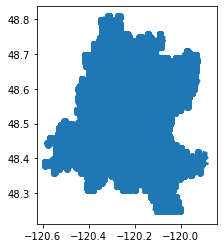

In [15]:
fig, ax = plt.subplots()
gdf.plot(ax=ax)
polygon_gdf.plot(ax=ax)